# Intermediate component separation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pylab
pylab.rcParams['figure.figsize'] = 12, 16

import healpy as hp
import pysm3
import pysm3.units as u

from fgbuster import get_instrument, get_sky, get_observation  # Predefined instrumental and sky-creation configurations
from fgbuster.visualization import corner_norm

# Imports needed for component separation
from fgbuster import (CMB, Dust, Synchrotron,  # sky-fitting model
                      basic_comp_sep)  # separation routine

## Input frequency maps
You have some frequency maps to clean, they can be either data or simulations.

### Simple case
Let's simulate a simple sky with `pysm`. ForeGroundBuster adds a couple of functions that make the process even easier.

In [4]:
NSIDE = 64
sky_simple = get_sky(NSIDE, 'c1d0s0') 
instrument = get_instrument('LiteBIRD')
freq_maps_simple = get_observation(instrument, sky_simple)
freq_maps_simple.shape

(15, 3, 49152)

We will focus on polarization-only component separation

In [7]:
freq_maps_simple = freq_maps_simple[:, 0:]  # Select polarization
print(freq_maps_simple.shape)

(15, 1, 49152)


### Spatially varying spectral indices
Let's prepare also maps with spatially varying spectral indices. Similarly to the simple case above, we run the following (notice `d1s1`)

In [5]:
NSIDE_PATCH = 8
sky_vary = get_sky(NSIDE, 'c1d1s1')

We can still modify the sky configuration. In this case, we change the nside over which the spectral indices are allowed to vary

In [6]:
for spectral_param in [sky_vary.components[1].mbb_index,
                       sky_vary.components[1].mbb_temperature,
                       sky_vary.components[2].pl_index]:
    spectral_param[:] = hp.ud_grade(hp.ud_grade(spectral_param.value, NSIDE_PATCH),
                                    NSIDE) * spectral_param.unit

Here is how they look like in constant and varying case. The rightmost plot shows the full resolution `pysm` template.

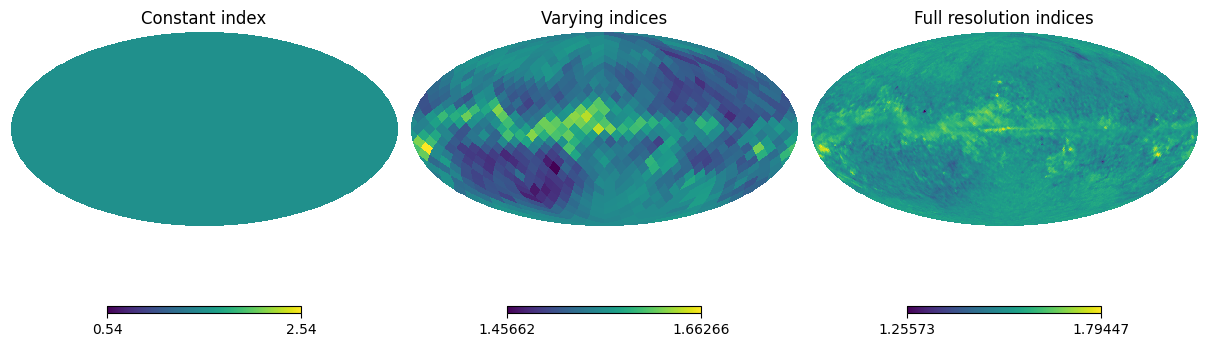

In [7]:
hp.mollview(sky_simple.components[1].mbb_index * np.ones(freq_maps_simple.shape[-1]),
            sub=(1,3,1), title='Constant index')
hp.mollview(sky_vary.components[1].mbb_index, sub=(1,3,2), title='Varying indices')
hp.mollview(get_sky(NSIDE, 'c1d1s1').components[1].mbb_index, sub=(1,3,3), title='Full resolution indices')

And now we generate the maps and select polarization

In [8]:
freq_maps_vary = get_observation(instrument, sky_vary)
freq_maps_vary = freq_maps_vary[:, 1:] # Select polarization

## Component separation
The sky model we fit for is defined as a list of `Component` objects. They can be easily build from analytic SEDs, but for popular component types these are already implemented.

In [9]:
components = [CMB(), Dust(353.), Synchrotron(23.)]

In [10]:
# The starting point of the fit is the pysm default value, so let's shift it
components[1].defaults = [1.6, 22.]
components[2].defaults = [-2.7]

We are now ready to perform the component separation

In [11]:
result = basic_comp_sep(components, instrument, freq_maps_simple, # verbose output
                        )

The input spectral parameters are recovered to numerical accuracy

In [12]:
inputs = [sky_simple.components[1].mbb_index,
          sky_simple.components[1].mbb_temperature.value,
          sky_simple.components[2].pl_index]

print("%-20s\t%s\t%s" % ('', 'Estimated', 'Input'))
for param, val, ref in zip(result.params, result.x, inputs):
    print("%-20s\t%f\t%f" % (param, val, ref))

                    	Estimated	Input
Dust.beta_d         	1.540000	1.540000
Dust.temp           	20.000000	20.000000
Synchrotron.beta_pl 	-3.000000	-3.000000


Their semi-analytic covariance is also provided, but remember that it is accurate only in the high signal-to-noise regime

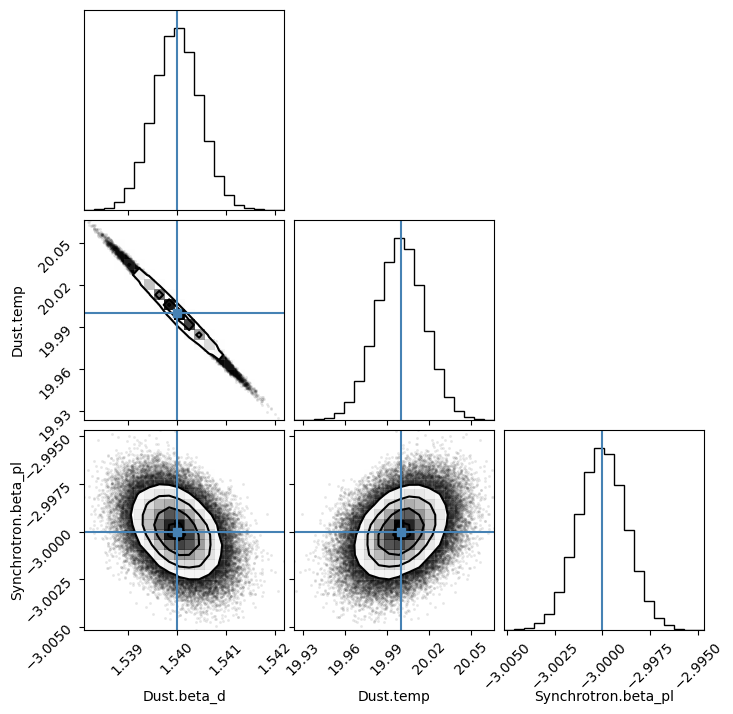

In [13]:
corner_norm(result.x, result.Sigma, labels=result.params, truths=inputs)

The amplitudes of the components are stacked in the `s` attribute and they are in the same format of the input frequency maps: Q and U healpix maps, in this case. Here is the U Stokes parameter for each of the components.

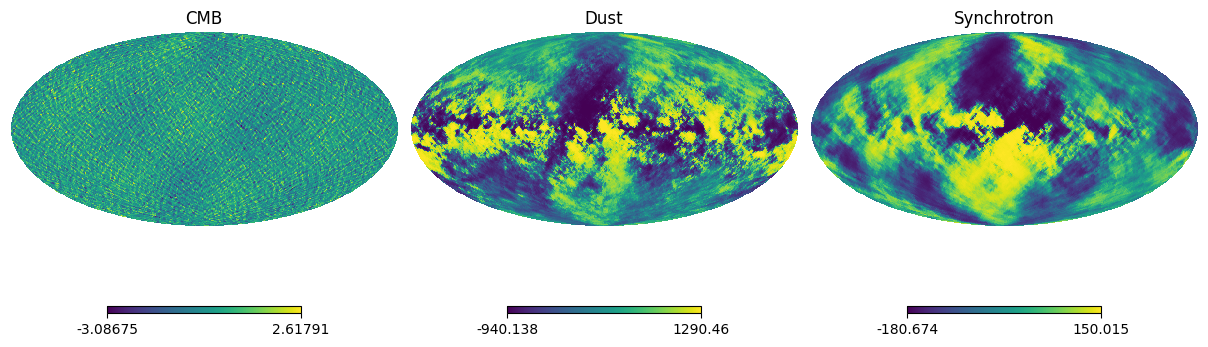

In [14]:
hp.mollview(result.s[0,1], title='CMB', sub=(1,3,1))
hp.mollview(result.s[1,1], title='Dust', norm='hist', sub=(1,3,2))
hp.mollview(result.s[2,1], title='Synchrotron', norm='hist', sub=(1,3,3))

By taking the difference with the input template, we see that the error in the reconstruction is negligible.

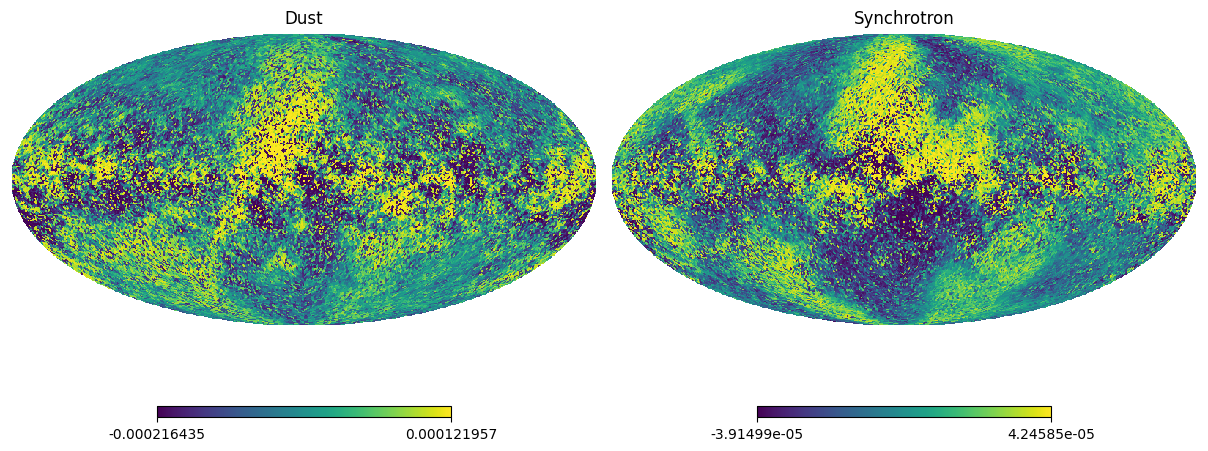

In [15]:
hp.mollview(result.s[1,1] 
            - sky_simple.components[1].U_ref.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(sky_simple.components[1].freq_ref_P)).value,
            title='Dust', norm='hist', sub=(1,2,1))
hp.mollview(result.s[2,1] 
            - sky_simple.components[2].U_ref.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(sky_simple.components[2].freq_ref_P)).value,
            title='Synchrotron', norm='hist', sub=(1,2,2))

## Component separation with varying indices
We now fit the spectral parameters independently over patches corresponding to healpix pixels with a given nside

In [16]:
nside_fit = NSIDE_PATCH
result_vary = basic_comp_sep(components, instrument, freq_maps_vary, nside_fit)

As in the previous case, the amplitudes of the components are stacked in the `s`.

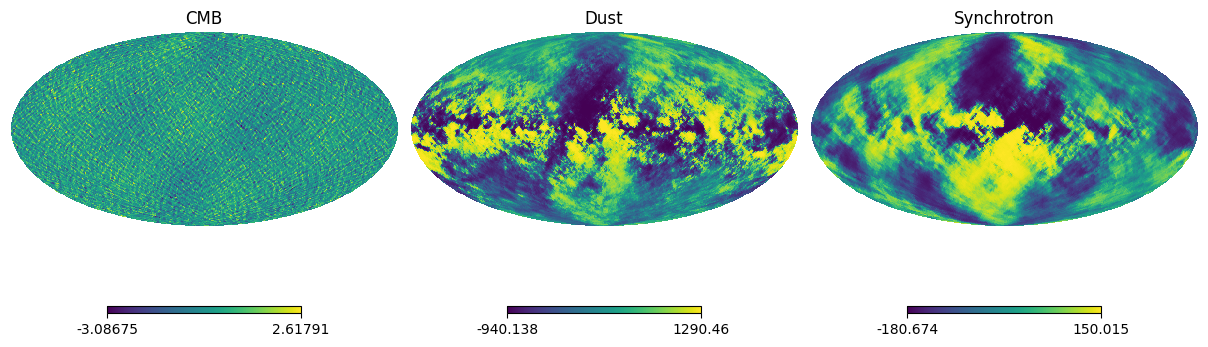

In [17]:
hp.mollview(result_vary.s[0,1], title='CMB', sub=(1,3,1))
hp.mollview(result_vary.s[1,1], title='Dust', norm='hist', sub=(1,3,2))
hp.mollview(result_vary.s[2,1], title='Synchrotron', norm='hist', sub=(1,3,3))

When we take the difference with the input templates, the residuals may be patchy. This is because the independent fit of the non-liner parameters has a different level of numerical accuracy for different patches. However, note that in all cases residuals are negligible: also this multi-patch cleaning has high accuracy. 

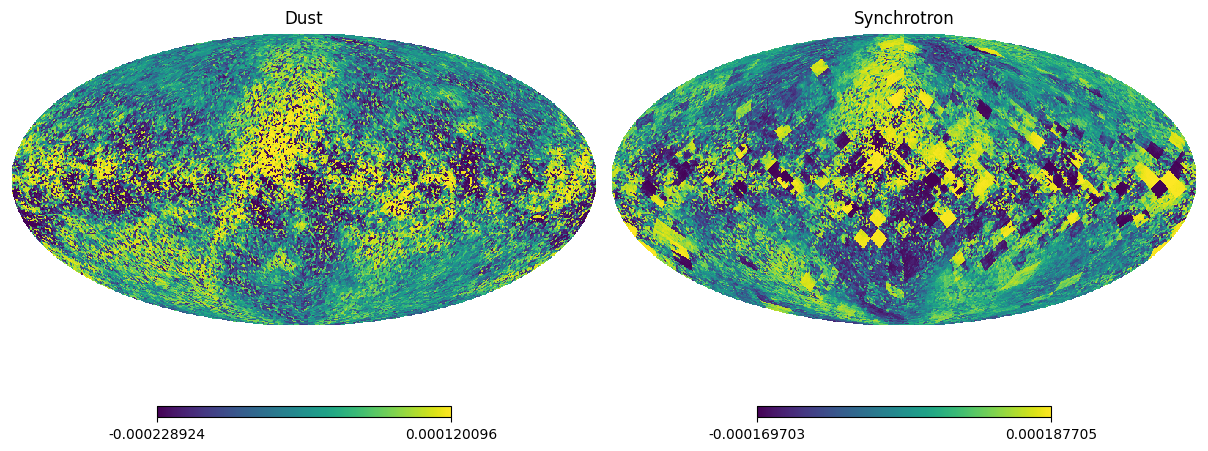

In [18]:
hp.mollview(result_vary.s[1,1] 
            - sky_vary.components[1].U_ref.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(sky_vary.components[1].freq_ref_P)).value,
            title='Dust', norm='hist', sub=(1,2,1))
hp.mollview(result_vary.s[2,1] 
            - sky_vary.components[2].U_ref.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(sky_vary.components[2].freq_ref_P)).value,
            title='Synchrotron', norm='hist', sub=(1,2,2))

The same is true for the non-linear parameters. Here are their reconstructed maps.

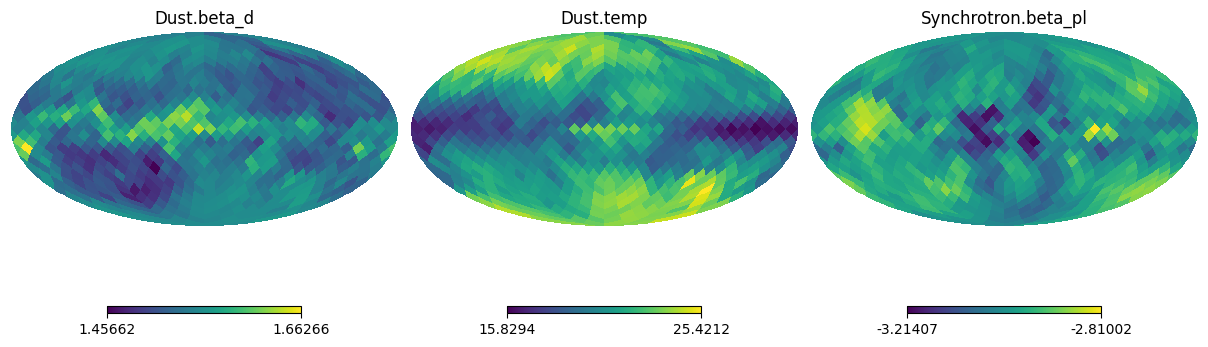

In [19]:
for i, par in enumerate(result.params):
    hp.mollview(result_vary.x[i], title=par, sub=(1,3,i+1))

And here is the difference with the input templates.

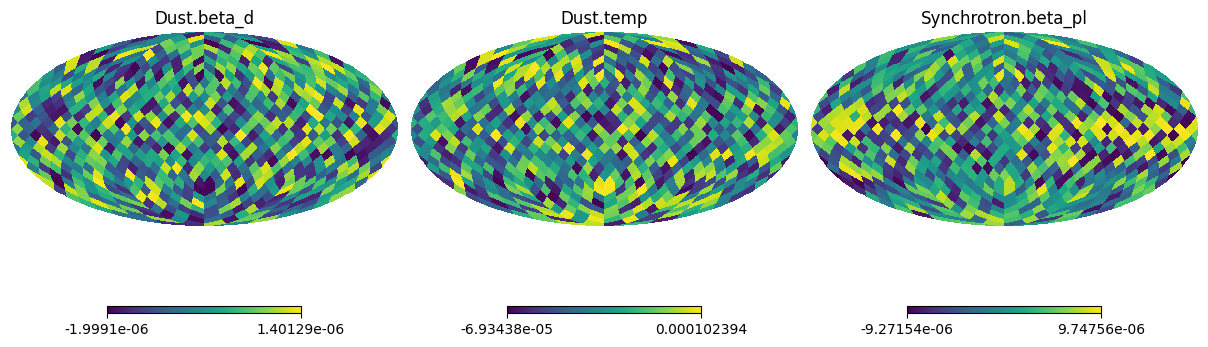

In [20]:
hp.mollview(hp.ud_grade(result_vary.x[0], NSIDE) - 
            sky_vary.components[1].mbb_index,
            title=result.params[0], norm='hist', sub=(1,3,1))
hp.mollview(hp.ud_grade(result_vary.x[1], NSIDE) - 
            sky_vary.components[1].mbb_temperature.value,
            title=result.params[1], norm='hist', sub=(1,3,2))
hp.mollview(hp.ud_grade(result_vary.x[2], NSIDE) - 
            sky_vary.components[2].pl_index,
            title=result.params[2], norm='hist', sub=(1,3,3))